In [1]:
import csv

# Open the input .data file
with open('adult.data', 'r') as datafile:
    lines = datafile.readlines()


# Open and create the output CSV file
with open('output.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)


    # Iterate over each line in the .data file
    for line in lines:
        # Split the line by commas and strip whitespace
        data = [x.strip() for x in line.split(',')]


        # Write the data to the CSV file
        writer.writerow(data)


In [2]:
import pandas as pd
from sklearn.impute import SimpleImputer
# Load the dataset from the CSV file
file_path = "output.csv"
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation',
           'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week',
           'native_country', 'income']
data = pd.read_csv(file_path, names=columns)


# Replace '?' with NaN
data.replace('?', pd.NA, inplace=True)


# Convert numerical columns from string to float
numerical_columns = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
data[numerical_columns] = data[numerical_columns].apply(pd.to_numeric, errors='coerce')


# Handle missing values for numerical columns
imputer_numerical = SimpleImputer(strategy='mean')
data[numerical_columns] = imputer_numerical.fit_transform(data[numerical_columns])


# Handle missing values for categorical columns
categorical_columns = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']
for column in categorical_columns:
    data[column].fillna(data[column].mode()[0], inplace=True)

In [3]:
# Check for duplicate rows
duplicate_rows = data[data.duplicated()]

# Remove duplicate rows
data = data.drop_duplicates()

# Print information about removed duplicates
print("Number of duplicate rows removed:", len(duplicate_rows))


Number of duplicate rows removed: 24


In [4]:
from sklearn.preprocessing import LabelEncoder
# Encode categorical variables
le = LabelEncoder()
encoded_values = {}  # Dictionary to store mapping of categories to numerical values

data['relationship'] = data['relationship'].replace(['Husband', 'Wife'], 'Not Single')
data['relationship'] = data['relationship'].replace(['Own-child', 'Not-in-family', 'Other-relative', 'Unmarried'], 'Single')

for column in categorical_columns:
    data[column] = le.fit_transform(data[column])
    encoded_values[column] = dict(zip(le.classes_, le.transform(le.classes_)))


# Fill missing values in 'income' column with its mode
data['income'] = data['income'].fillna(data['income'].mode()[0])


# Convert 'income' column into binary values (0 for <=50k and 1 for >50k)
data['income'] = data['income'].apply(lambda x: 0 if x.strip() == '<=50K' else 1)


# Print the mapping for each categorical column
for column, mapping in encoded_values.items():
    print(f"{column}: {mapping}")


workclass: {'Federal-gov': 0, 'Local-gov': 1, 'Never-worked': 2, 'Private': 3, 'Self-emp-inc': 4, 'Self-emp-not-inc': 5, 'State-gov': 6, 'Without-pay': 7}
education: {'10th': 0, '11th': 1, '12th': 2, '1st-4th': 3, '5th-6th': 4, '7th-8th': 5, '9th': 6, 'Assoc-acdm': 7, 'Assoc-voc': 8, 'Bachelors': 9, 'Doctorate': 10, 'HS-grad': 11, 'Masters': 12, 'Preschool': 13, 'Prof-school': 14, 'Some-college': 15}
marital_status: {'Divorced': 0, 'Married-AF-spouse': 1, 'Married-civ-spouse': 2, 'Married-spouse-absent': 3, 'Never-married': 4, 'Separated': 5, 'Widowed': 6}
occupation: {'Adm-clerical': 0, 'Armed-Forces': 1, 'Craft-repair': 2, 'Exec-managerial': 3, 'Farming-fishing': 4, 'Handlers-cleaners': 5, 'Machine-op-inspct': 6, 'Other-service': 7, 'Priv-house-serv': 8, 'Prof-specialty': 9, 'Protective-serv': 10, 'Sales': 11, 'Tech-support': 12, 'Transport-moving': 13}
relationship: {'Not Single': 0, 'Single': 1}
race: {'Amer-Indian-Eskimo': 0, 'Asian-Pac-Islander': 1, 'Black': 2, 'Other': 3, 'White

In [5]:
column_data_types = data.dtypes
print(column_data_types)

age               float64
workclass           int32
fnlwgt            float64
education           int32
education_num     float64
marital_status      int32
occupation          int32
relationship        int32
race                int32
sex                 int32
capital_gain      float64
capital_loss      float64
hours_per_week    float64
native_country      int32
income              int64
dtype: object


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define features (X) and target (y)
X = data.drop(columns=['income'])  
y = data['income']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

In [7]:
# Calculate correlations with the target variable ('Income')
correlations = data.corr()['income'].sort_values(ascending=False)

# Print correlations
print(correlations)

income            1.000000
education_num     0.335270
age               0.234036
hours_per_week    0.229657
capital_gain      0.223335
sex               0.215954
capital_loss      0.150500
education         0.079363
race              0.071840
occupation        0.034503
native_country    0.022849
workclass         0.002703
fnlwgt           -0.009502
marital_status   -0.199191
relationship     -0.448383
Name: income, dtype: float64


In [8]:
columns_to_drop = ['race', 'fnlwgt', 'education', 'occupation', 'native_country', 'workclass']
data_filtered = data.drop(columns=columns_to_drop)

In [9]:
# Assuming data is your DataFrame with filled missing values
data_filtered.to_csv("filled_data.csv", index=False)


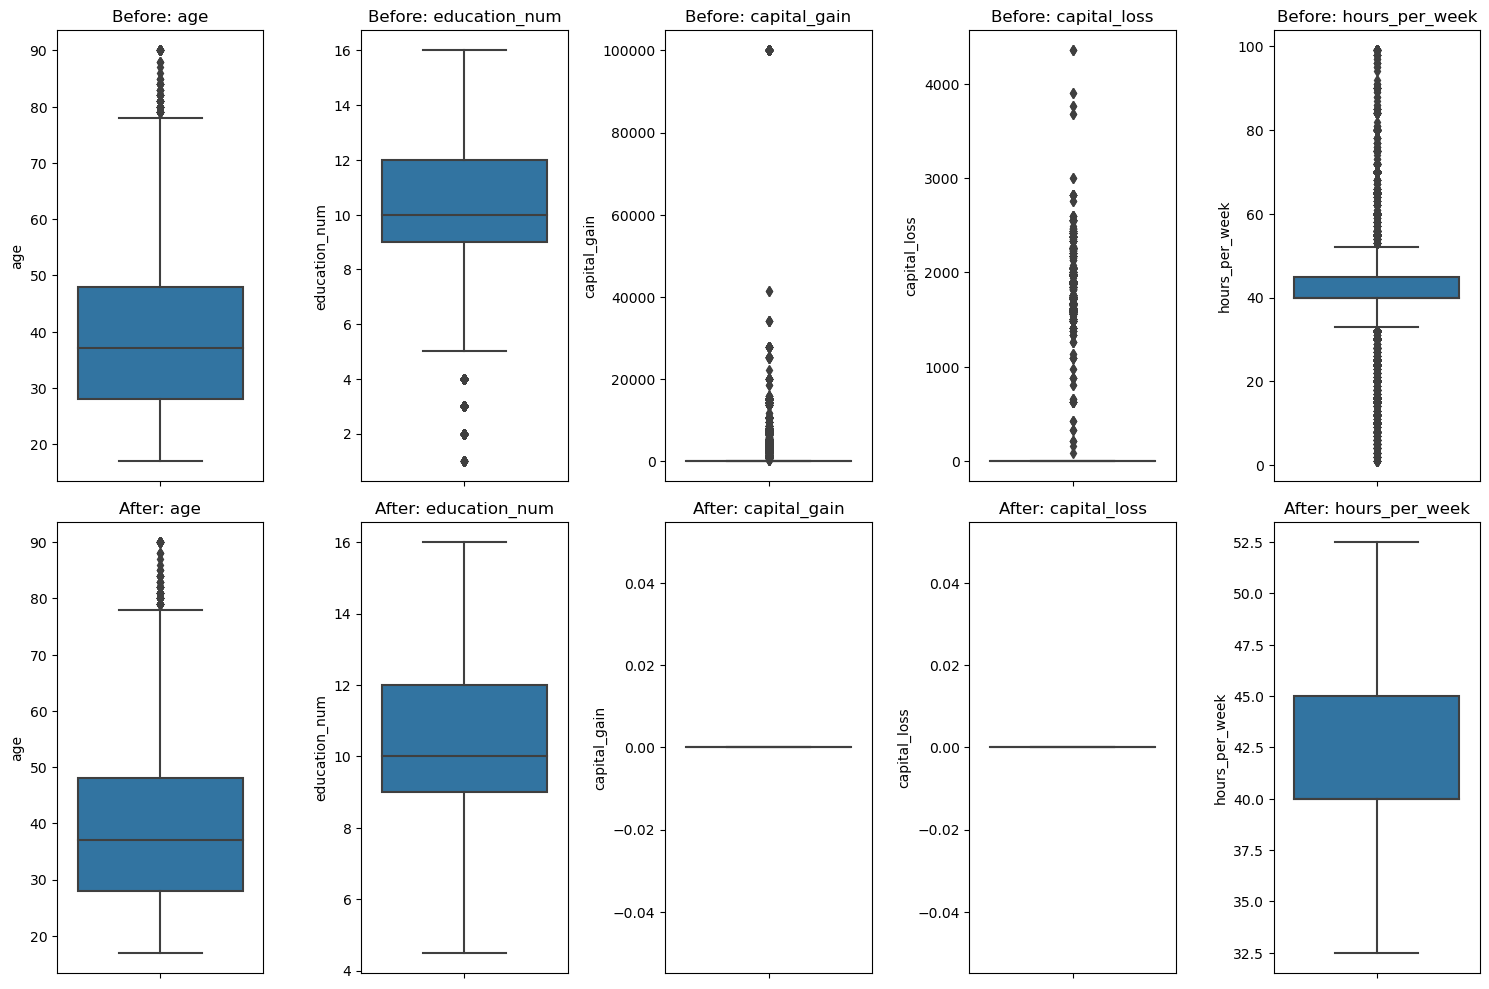

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the numerical columns
numerical_columns = ['age',  'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']

# Define a function to handle outliers
def handle_outliers_with_iqr(column):
    # Calculate quartiles
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1

    # Calculate lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count occurrences of outliers
    outliers = (column < lower_bound) | (column > upper_bound)
    outlier_count = outliers.sum()

    # If the outlier count is less than 200, drop rows containing outliers
    if outlier_count < 200:
        return column
    else:
        # Round outliers to the upper or lower bound
        return column.apply(lambda x: upper_bound if x > upper_bound else (lower_bound if x < lower_bound else x))

# Apply outlier handling for each numerical column
for column in numerical_columns:
    data_filtered[column] = handle_outliers_with_iqr(data_filtered[column])

# Create subplots for the box plots before and after outlier handling
fig, axes = plt.subplots(nrows=2, ncols=len(numerical_columns), figsize=(15, 10))

# Plot box plots before outlier handling
for i, column in enumerate(numerical_columns):
    sns.boxplot(y=data[column], ax=axes[0, i])
    axes[0, i].set_title(f'Before: {column}')

# Plot box plots after outlier handling
for i, column in enumerate(numerical_columns):
    sns.boxplot(y=data_filtered[column], ax=axes[1, i])
    axes[1, i].set_title(f'After: {column}')

# Adjust layout and show plots
plt.tight_layout()
plt.show()


In [10]:
# Save the modified data into another CSV file
output_file_path = "new_data.csv"
data_filtered.to_csv(output_file_path, index=False)

In [11]:
import pandas as pd

# Load the cleaned and transformed dataset
data_filtered = pd.read_csv('new_data.csv')

# Count the occurrences of each class in the target variable
class_counts = data_filtered['income'].value_counts()

# Print the class counts
print("Class Counts:")
print(class_counts)

# Calculate the class distribution as percentages
class_distribution = class_counts / class_counts.sum() * 100

# Print the class distribution
print("\nClass Distribution (%):")
print(class_distribution)


Class Counts:
income
0    24699
1     7839
Name: count, dtype: int64

Class Distribution (%):
income
0    75.908169
1    24.091831
Name: count, dtype: float64


In [13]:
!pip install imbalanced-learn


In [12]:
# Import SMOTE
from imblearn.over_sampling import SMOTE

# Instantiate SMOTE
smote = SMOTE(random_state=42)

# Resample the dataset
X_resampled, y_resampled = smote.fit_resample(X, y)

In [13]:
import pandas as pd

y_resampled_series = pd.Series(y_resampled)

# Print class counts
class_counts = y_resampled_series.value_counts()
print("Class Counts:")
print(class_counts)

# Print class distribution (%)
class_distribution = y_resampled_series.value_counts(normalize=True) * 100
print("\nClass Distribution (%):")
print(class_distribution)


Class Counts:
income
0    24699
1    24699
Name: count, dtype: int64

Class Distribution (%):
income
0    50.0
1    50.0
Name: proportion, dtype: float64


In [14]:
import pandas as pd

# Assuming you have X_resampled and y_resampled after applying SMOTE

# Combine X_resampled and y_resampled into a single DataFrame
resampled_data = pd.DataFrame(X_resampled, columns=X.columns)  # Assuming X has column names
resampled_data['income'] = y_resampled  # Assuming 'income' is the target column name

# Save the resampled data to a CSV file
resampled_data.to_csv('resampled_data.csv', index=False)


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load the cleaned and transformed dataset
data = pd.read_csv('resampled_data.csv')

# Define features (X) and target (y)
X = data.drop(columns=['income']) 
y = data['income']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Naive Bayes Classifier
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)
nb_predictions = nb_classifier.predict(X_test)

# Evaluate Naive Bayes Classifier
print("Naive Bayes Classifier:")
print("Accuracy:", accuracy_score(y_test, nb_predictions))
print("Classification Report:")
print(classification_report(y_test, nb_predictions))

# Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
rf_predictions = rf_classifier.predict(X_test)

# Evaluate Random Forest Classifier
print("\nRandom Forest Classifier:")
print("Accuracy:", accuracy_score(y_test, rf_predictions))
print("Classification Report:")
print(classification_report(y_test, rf_predictions))


Naive Bayes Classifier:
Accuracy: 0.6270242914979757
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.94      0.72      4978
           1       0.84      0.31      0.45      4902

    accuracy                           0.63      9880
   macro avg       0.71      0.62      0.58      9880
weighted avg       0.71      0.63      0.58      9880


Random Forest Classifier:
Accuracy: 0.8979757085020242
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      4978
           1       0.90      0.89      0.90      4902

    accuracy                           0.90      9880
   macro avg       0.90      0.90      0.90      9880
weighted avg       0.90      0.90      0.90      9880



In [16]:
from sklearn.metrics import accuracy_score

# Naive Bayes Classifier
nb_train_predictions = nb_classifier.predict(X_train)
nb_train_accuracy = accuracy_score(y_train, nb_train_predictions)
print("Naive Bayes Training Accuracy:", nb_train_accuracy)

# Random Forest Classifier
rf_train_predictions = rf_classifier.predict(X_train)
rf_train_accuracy = accuracy_score(y_train, rf_train_predictions)
print("Random Forest Training Accuracy:", rf_train_accuracy)


Naive Bayes Training Accuracy: 0.6250569360797611
Random Forest Training Accuracy: 0.9999493901513234



Confusion Matrix for Random Forest Classifier:


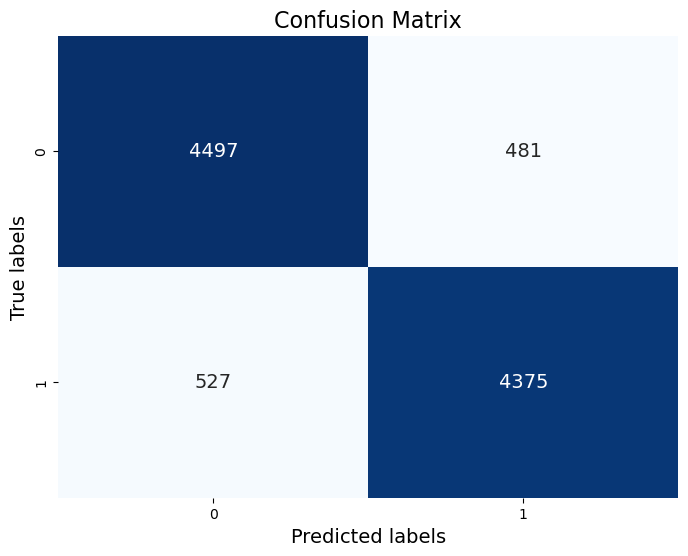


Confusion Matrix for Naive Bayes Classifier:


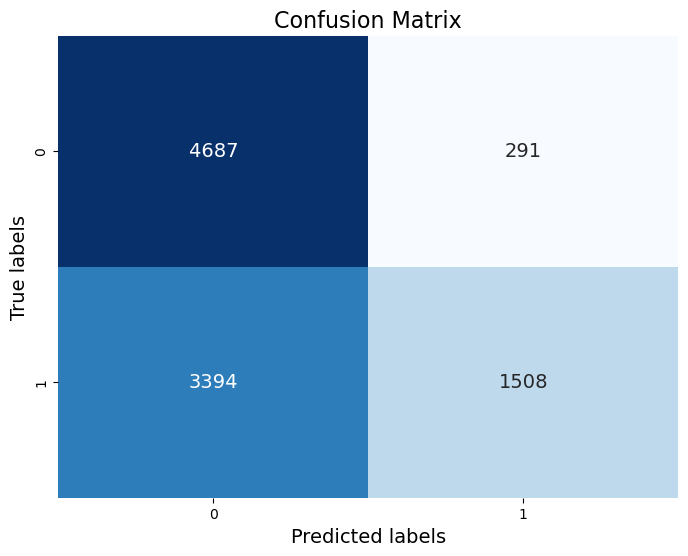

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Print Confusion Matrix for Random Forest Classifier
print("\nConfusion Matrix for Random Forest Classifier:")
cm = confusion_matrix(y_test, rf_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False, annot_kws={"size": 14})
plt.xlabel('Predicted labels', fontsize=14)
plt.ylabel('True labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

# Print Confusion Matrix for Naive Bayes Classifier
print("\nConfusion Matrix for Naive Bayes Classifier:")
cm_nb = confusion_matrix(y_test, nb_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nb, annot=True, cmap='Blues', fmt='g', cbar=False, annot_kws={"size": 14})
plt.xlabel('Predicted labels', fontsize=14)
plt.ylabel('True labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()